In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd '/content/drive/MyDrive/dataset brain tumor/dataset'

In [ ]:
!unzip 'axial_t1wce_2_class' -d '/dataset unzipped'

In [ ]:
!unzip 'coronal_t1wce_2_class' -d '/dataset unzipped'

In [ ]:
!unzip 'sagittal_t1wce_2_class' -d '/dataset unzipped'

In [ ]:
# Data Manipulation
import numpy as np
import pandas as pd
import os
# Visualization/Image Processing
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, MaxPooling2D, Dense, Activation, Dropout
from PIL import Image
# Other
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
import xml.etree.ElementTree as ET
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [ ]:
%cd '/dataset unzipped'

In [ ]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightl
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    #thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
    thresh = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)[1]
    #thresh = cv2.erode(thresh, None, iterations=2)
    #thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image,extLeft,extRight,extTop,extBot

In [ ]:
#Codice per rendere l'immagine quadrata 
def make_square(im, fill_color=(0, 0, 0, 0)):
    x, y = im.shape[0], im.shape[1]
    size = max(x, y)
    BLACK = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im,int((size-y)/2),int((size-y)/2),int((size-x)/2),int((size-x)/2),cv2.BORDER_CONSTANT, value = BLACK)
    return new_im

In [ ]:
#Bounding box with one tumor
lab = ['axial_t1wce_2_class','coronal_t1wce_2_class', 'sagittal_t1wce_2_class']
X_train = []
bb = []
temp_array  = []
count = 0;
image_size = 180
for i in lab:
    folderPath = os.path.join('./',i,'images','train')
    for j in sorted(os.listdir(folderPath)):
        #load the image
        img = cv2.imread(os.path.join(folderPath,j))
        image_width.append(img.shape[1])
        image_height.append(img.shape[0])
        # crop the brain and ignore the unnecessary rest part of the image
        image,extLeft,extRight,extTop,extBot = crop_brain_contour(img,False)
        extLeft_coords_x.append(extLeft[0])
        extLeft_coords_y.append(extLeft[1])
        extRight_coords_x.append(extRight[0])
        extRight_coords_y.append(extRight[1])
        extTop_coords_x.append(extTop[0])
        extTop_coords_y.append(extTop[1])
        extBot_coords_x.append(extBot[0])
        extBot_coords_y.append(extBot[1])
        # resize image
        image = cv2.resize(image, dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC)
        
        #if img.shape[0] != img.shape[1]:
        #    img = make_square(img, fill_color=(0, 0, 0, 0))
        #img = cv2.resize(img,(image_size, image_size))

        X_train.append(img)
image_index = 0
bb_train = np.zeros((len(X_train),4))
for i in lab:
    labelsPath = os.path.join('./',i,'labels','train')
    for j in sorted(os.listdir(labelsPath)):
        with open(os.path.join(labelsPath,j), encoding="utf-8") as f:
            for line in f:
                num = list(map(float,line.split(" ")))
                temp_array = []
                for k in num:
                  temp_array.append(k)
                temp_array.pop(0)

                temp_array[0] = temp_array[0]*image_width[count] #centro x immagine originale
                temp_array[0] = temp_array[0]-extLeft_coords_x[count]
                temp_array[0] = (temp_array[0]/(extRight_coords_x[count]-extLeft_coords_x[count]))*image_size
                
                temp_array[1] = temp_array[1]*image_height[count]
                temp_array[1] = temp_array[1]-extTop_coords_y[count]
                temp_array[1] = (temp_array[1]/(extBot_coords_y[count]-extTop_coords_y[count]))*image_size
                
                temp_array[2] = temp_array[2]*(image_width[count])
                temp_array[2] = (temp_array[2]/(extRight_coords_x[count]-extLeft_coords_x[count]))*image_size
                
                temp_array[3] = temp_array[3]*(image_height[count])
                temp_array[3] = (temp_array[3]/(extBot_coords_y[count]-extTop_coords_y[count]))*image_size

                #print(temp_array)
                bb_train[image_index] = np.array([temp_array])
                #print(bb_train[image_index])
            image_index += 1
            count += 1

X_test = []
for i in lab:
    folderPath = os.path.join('./',i,'images','test')
    for j in sorted(os.listdir(folderPath)):
        #load the image
        img = cv2.imread(os.path.join(folderPath,j))
        images_width_test.append(img.shape[1])
        images_height_test.append(img.shape[0])
        # crop the brain and ignore the unnecessary rest part of the image
        image_test,extLeft_test,extRight_test,extTop_test,extBot_test = crop_brain_contour(img,False)
        extLeft_coords_x_test.append(extLeft_test[0])
        extLeft_coords_y_test.append(extLeft_test[1])
        extRight_coords_x_test.append(extRight_test[0])
        extRight_coords_y_test.append(extRight_test[1])
        extTop_coords_x_test.append(extTop_test[0])
        extTop_coords_y_test.append(extTop_test[1])
        extBot_coords_x_test.append(extBot_test[0])
        extBot_coords_y_test.append(extBot_test[1])
        # resize image
        image_test = cv2.resize(image_test, dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC)
        #if img.shape[0] != img.shape[1]:
            #img = make_square(img, fill_color=(0, 0, 0, 0))
        #img = cv2.resize(img,(image_size, image_size))
        X_test.append(image_test)

image_index = 0
count_test = 0;
bb_test = np.zeros((len(X_test),4))
for i in lab:
    labelsPath = os.path.join('./',i,'labels','test')
    for j in sorted(os.listdir(labelsPath)):
        with open(os.path.join(labelsPath,j), encoding="utf-8") as f:
            for line in f:
                num = list(map(float,line.split(" ")))
                temp_array = []
                for k in num:
                    temp_array.append(k)
                temp_array.pop(0)

                #width_new_im.append(extRight_coords_x_test[count_test]-extLeft_coords_x_test[count_test])
                #height_new_im.append(extBot_coords_y_test[count_test]-extTop_coords_y_test[count_test])
                
                
                temp_array[0] = temp_array[0]*images_width_test[count_test] #centro x immagine originale
                temp_array[0] = temp_array[0]-extLeft_coords_x_test[count_test]
                temp_array[0] = (temp_array[0]/(extRight_coords_x_test[count_test]-extLeft_coords_x_test[count_test]))*image_size
                
                temp_array[1] = temp_array[1]*images_height_test[count_test]
                temp_array[1] = temp_array[1]-extTop_coords_y_test[count_test]
                temp_array[1] = (temp_array[1]/(extBot_coords_y_test[count_test]-extTop_coords_y_test[count_test]))*image_size
                
                temp_array[2] = temp_array[2]*(images_width_test[count_test])
                temp_array[2] = (temp_array[2]/(extRight_coords_x_test[count_test]-extLeft_coords_x_test[count_test]))*image_size
                
                
                temp_array[3] = temp_array[3]*(images_height_test[count_test])
                temp_array[3] = (temp_array[3]/(extBot_coords_y_test[count_test]-extTop_coords_y_test[count_test]))*image_size                 
            
                bb_test[image_index] = np.array([temp_array])
                #print(bb_test[image_index])
            image_index += 1
            count_test += 1
print(bb_test[30])
print(extRight_coords_x_test[30])
print(extLeft_coords_x_test[30])

100%|█████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 115.15it/s]


In [ ]:
#prepare dataset 
train_dataset = ImageDataGenerator()
val_dataset = ImageDataGenerator()

In [ ]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    #horizontal_flip=True
    )
val_data_gen = ImageDataGenerator(rescale = 1./255
)
test_data_gen = ImageDataGenerator(rescale = 1./255
)


In [ ]:
#array conversion
X_train = np.array(X_train)
X_test = np.array(X_test)

In [ ]:
#Shuffle
X_train, bb_train = shuffle(X_train, bb_train)

In [ ]:
#Validation set created
X_train, X_val, bb_train, bb_val = train_test_split(X_train, bb_train, test_size = 0.1, shuffle = False)

In [ ]:
tf.keras.backend.set_image_data_format('channels_last')
BATCH_SIZE = 16
save_path = os.path.join('./', 'model_from_scratch')
train_dataset = train_dataset.flow(X_train, bb_train, batch_size = BATCH_SIZE)
val_dataset = val_dataset.flow(X_val, bb_val, batch_size = BATCH_SIZE)

In [ ]:
input_ = Input(shape=[180,180, 3])

x = input_

for i in range(10):
    n_filters = 2**(i + 3)
    x = Conv2D(n_filters, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2, padding='same')(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(4, name='coords')(x)

model = tf.keras.models.Model(input_, output)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 180, 180, 8)       224       
_________________________________________________________________
batch_normalization_25 (Batc (None, 180, 180, 8)       32        
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 90, 90, 8)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 90, 90, 16)        1168      
_________________________________________________________________
batch_normalization_26 (Batc (None, 90, 90, 16)        64        
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 45, 45, 16)        0   

In [ ]:
# Draw the predicted bounding boxes
def display_image(img, bbox_coords, pred_coords):
    if len(bbox_coords) == 4: #in rosso
        xmin, ymin, height, width = bbox_coords
        img = cv2.rectangle(img, (int(xmin-height/2), int(ymin-width/2)), (int(xmin+height/2), int(ymin+width/2)), (255, 0, 0), 1)
    print(len(pred_coords))    
    if len(pred_coords) == 4: #in verde
        xmin1, ymin1, height1, width1 = pred_coords
        img = cv2.rectangle(img, (int(xmin1-height1/2), int(ymin1-width1/2)), (int(xmin1+height1/2), int(ymin1+width1/2)), (0, 255, 0), 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [ ]:
#To test the model
def test_model(model):
    rand_index = np.random.randint(0, bb_test.shape[0])
    pred_bbox = model.predict(X_test)[rand_index]
    img_original = X_test[rand_index]
    img = img_original.copy()
    coords = bb_test[rand_index]
    #example, label = next(datagen)
    #X = example['image']
    #y = label['coords']
    #pred_bbox = model.predict(X)[0]
    #img = X[0]
    #gt_coords = y[0]
    
    display_image(img,bbox_coords = coords, pred_coords=pred_bbox)

def test(model):
    
    plt.figure(figsize=(15,7))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        test_model(model)    
    plt.show()

class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)
        

In [ ]:
callbacks_list = [
    ShowTestImages()
]

In [ ]:
METRIC_THRESH = 0.3

def raw_iou(y_true, y_pred):
    results = []
    for i in range(0,y_true.shape[0]):


        boxTrue_width = y_true[i,2]
        boxTrue_height = y_true[i,3]
        x_boxTrue_tleft = y_true[i,0]-boxTrue_width/2  # numpy index selection
        y_boxTrue_tleft = y_true[i,1]-boxTrue_height/2
    
        area_boxTrue = (boxTrue_width * boxTrue_height)

        # boxPred
        boxPred_width = y_pred[i,2]
        boxPred_height = y_pred[i,3]
        x_boxPred_tleft = y_pred[i,0]-boxPred_width/2  
        y_boxPred_tleft = y_pred[i,1]-boxPred_height/2
    
        area_boxPred = (boxPred_width * boxPred_height)


        # calculate the bottom right coordinates for boxTrue and boxPred

        # boxTrue
        x_boxTrue_br = x_boxTrue_tleft + boxTrue_width
        y_boxTrue_br = y_boxTrue_tleft + boxTrue_height # Version 2 revision

        # boxPred
        x_boxPred_br = x_boxPred_tleft + boxPred_width
        y_boxPred_br = y_boxPred_tleft + boxPred_height # Version 2 revision


        # calculate the top left and bottom right coordinates for the intersection box, boxInt

        # boxInt - top left coords
        x_boxInt_tleft = np.max([x_boxTrue_tleft,x_boxPred_tleft])
        y_boxInt_tleft = np.max([y_boxTrue_tleft,y_boxPred_tleft]) # Version 2 revision

        # boxInt - bottom right coords
        x_boxInt_br = np.min([x_boxTrue_br,x_boxPred_br])
        y_boxInt_br = np.min([y_boxTrue_br,y_boxPred_br]) 

        # Calculate the area of boxInt, i.e. the area of the intersection 
        # between boxTrue and boxPred.
        # The np.max() function forces the intersection area to 0 if the boxes don't overlap.
        
        
        # Version 2 revision
        area_of_intersection = \
        np.max([0,(x_boxInt_br - x_boxInt_tleft)]) * np.max([0,(y_boxInt_br - y_boxInt_tleft)])

        iou = np.mean(area_of_intersection / ((area_boxTrue + area_boxPred) - area_of_intersection)).astype(np.float32)


        # This must match the type used in py_func
        results.append(iou)
    return np.mean(results)

def IoU(y_true, y_pred):
    iou = tf.numpy_function(raw_iou, [y_true, y_pred], tf.float32)
    return iou

In [ ]:
model.compile(
    loss={
        'coords': 'mae'
    },
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=[IoU]
)

Epoch 1/30
50/50 [==============================] - 368s 7s/step - loss: 19.7620 - accuracy: 0.6152 - val_loss: 29.4276 - val_accuracy: 0.3182

Epoch 00001: val_loss improved from inf to 29.42757, saving model to .\model_from_scratch
INFO:tensorflow:Assets written to: .\model_from_scratch\assets
4
4
4


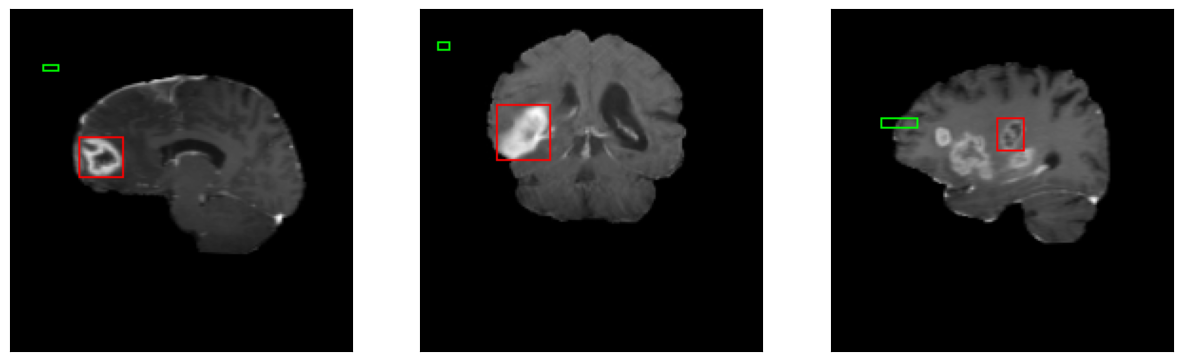

Epoch 2/30
50/50 [==============================] - 388s 8s/step - loss: 13.7226 - accuracy: 0.7316 - val_loss: 19.0733 - val_accuracy: 0.6591

Epoch 00002: val_loss improved from 29.42757 to 19.07326, saving model to .\model_from_scratch
INFO:tensorflow:Assets written to: .\model_from_scratch\assets
4
4
4


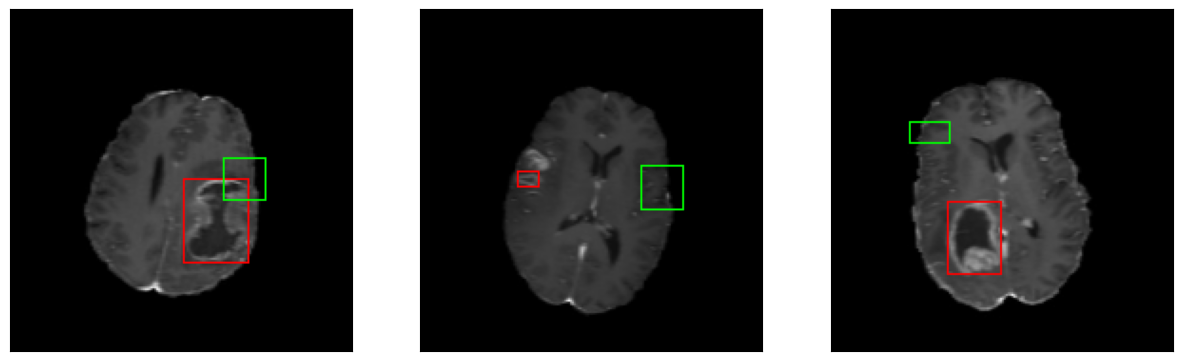

Epoch 3/30
50/50 [==============================] - 458s 9s/step - loss: 13.6005 - accuracy: 0.7418 - val_loss: 15.3053 - val_accuracy: 0.7386

Epoch 00003: val_loss improved from 19.07326 to 15.30535, saving model to .\model_from_scratch
INFO:tensorflow:Assets written to: .\model_from_scratch\assets
4
4
4


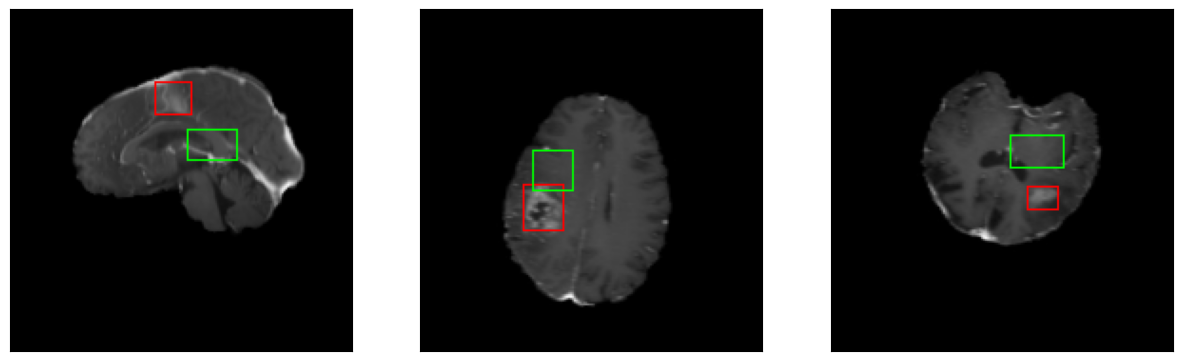

Epoch 4/30
50/50 [==============================] - 407s 8s/step - loss: 13.0941 - accuracy: 0.7380 - val_loss: 16.7960 - val_accuracy: 0.8068

Epoch 00004: val_loss did not improve from 15.30535
4
4
4


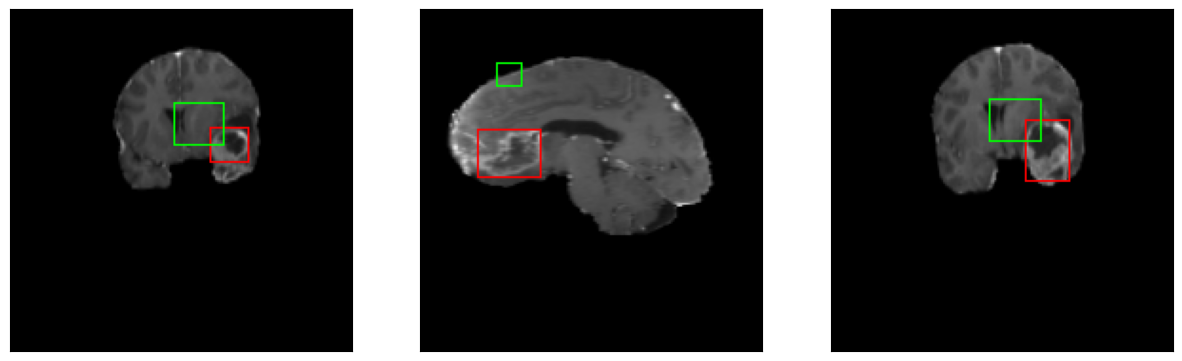

Epoch 5/30
50/50 [==============================] - 397s 8s/step - loss: 12.7094 - accuracy: 0.7532 - val_loss: 14.6095 - val_accuracy: 0.7045

Epoch 00005: val_loss improved from 15.30535 to 14.60946, saving model to .\model_from_scratch
INFO:tensorflow:Assets written to: .\model_from_scratch\assets
4
4
4


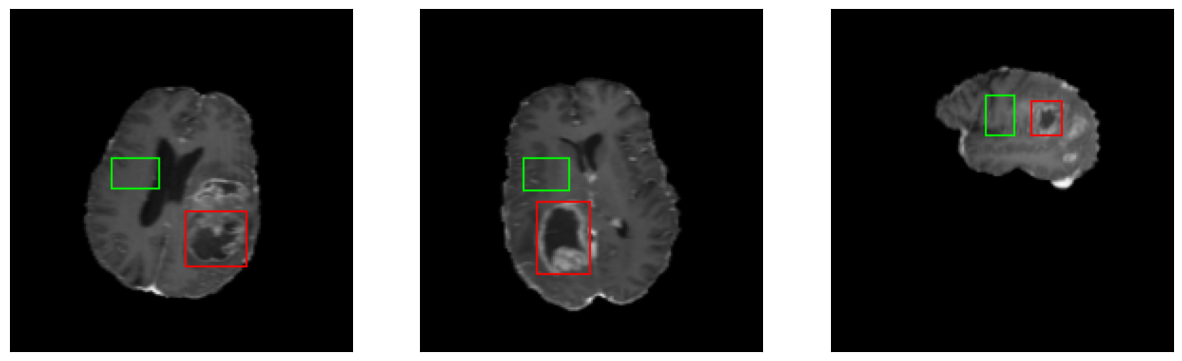

Epoch 6/30
27/50 [===============>..............] - ETA: 2:55 - loss: 13.2754 - accuracy: 0.7227

In [ ]:
model.fit(
        train_dataset,
        epochs=30,
        validation_data = val_dataset,
        callbacks = callbacks_list
        )

In [ ]:
#Save model
model.save('./model_fromScratch')

INFO:tensorflow:Assets written to: ./model_efficientNet\assets


INFO:tensorflow:Assets written to: ./model_efficientNet\assets


In [ ]:
model = tf.keras.models.load_model('./model_fromScratch')

<AxesSubplot:>

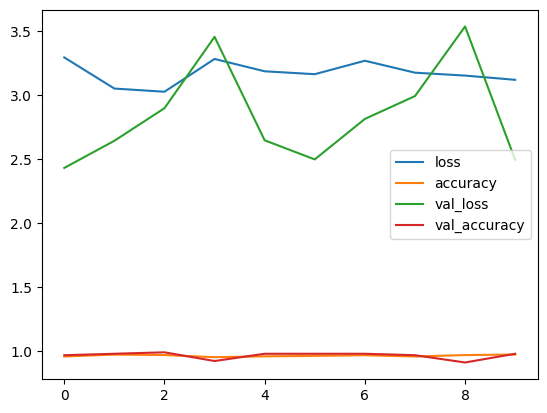

In [ ]:
pd.DataFrame(model.history.history).plot()